In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from copy import deepcopy
import seaborn as sns
sns.set()

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv('Iris.csv')
Y = df.iloc[:,-1].values
df = df.iloc[:,1:-1]
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [3]:
def PCA(X, dimensions = 2):
    X = X - np.tile(np.mean(X, 0), (X.shape[0], 1))
    _, eigenvectors = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, eigenvectors[:, :dimensions])
    return Y

In [4]:
labels = np.unique(Y)
Y = LabelEncoder().fit_transform(Y)
X = PCA(df.values)
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size = 0.2)

In [5]:
def divide(X, i, threshold):
    more_than = np.where(X[:,i]>=threshold)[0]
    less_than = np.setxor1d(np.arange(X.shape[0]), more_than)
    return np.array([X[more_than,:], X[less_than,:]])

def calculate_entropy(y):
    unique_labels = np.unique(y)
    entropy = 0
    for label in unique_labels:
        count = len(y[y == label])
        p = count / len(y)
        entropy += -p * np.log2(p)
    return entropy

class Node:
    def __init__(self, feature=None, threshold=None, val=None, true_b=None, false_b=None):
        self.feature = feature
        self.threshold = threshold
        self.val = val
        self.true_b = true_b
        self.false_b = false_b
        
class DecisionTree:
    def __init__(self, min_samples_split=2, min_impurity = 1e-8, max_depth=float('inf')):
        self.root = None
        self.min_samples_split = min_samples_split
        self.min_impurity = min_impurity
        self.max_depth = max_depth
        self.impurity_calculation = None
        self.leaf_value_calculation = None
        
    def _cal_information_gain(self, Y, y_more, y_less):
        p = y_more.shape[0] / Y.shape[0]
        H = calculate_entropy(Y)
        return H - p * calculate_entropy(y_more) * (1-p) * calculate_entropy(y_less)
    
    def _vote(self, Y):
        counts = np.bincount(Y[:,0].astype('int64'))
        return np.argmax(counts)
        
    def build_tree(self, X, Y, current_depth=0):
        largest_impurity = 0
        best_criteria = None
        best_sets = None
        if len(Y.shape) == 1:
            Y = np.expand_dims(Y, axis=1)
        XY = np.concatenate((X, Y), axis=1)
        n_samples, n_features = np.shape(X)
        if n_samples >= self.min_samples_split and current_depth <= self.max_depth:
            for i in range(n_features):
                feature_values = np.expand_dims(X[:, i], axis=1)
                unique_values = np.unique(feature_values)
                for threshold in unique_values:
                    XY_more, XY_less = divide(XY, i, threshold)
                    if XY_more.shape[0] > 0 and XY_less.shape[0]:
                        y_more = XY_more[:, n_features:]
                        y_less = XY_less[:, n_features:]
                        impurity = self._cal_information_gain(Y, y_more, y_less)
                        if impurity > largest_impurity:
                            largest_impurity = impurity
                            best_criteria = {"i": i, "threshold": threshold}
                            best_sets = {
                                'left_X': XY_more[:, :n_features],
                                'left_Y': XY_more[:, n_features:],
                                'right_X': XY_less[:, :n_features],
                                'right_Y': XY_less[:, n_features:],
                            }
        if largest_impurity > self.min_impurity:
            T_branch = self.build_tree(best_sets["left_X"], best_sets["left_Y"], current_depth + 1)
            F_branch = self.build_tree(best_sets["right_X"], best_sets["right_Y"], current_depth + 1)
            return Node(feature=best_criteria['i'],threshold=best_criteria['threshold'],
                       true_b=T_branch, false_b=F_branch)
        selected_val = self._vote(Y)
        return Node(val=selected_val)
    
    def fit(self, X, Y):
        self.root = self.build_tree(X, Y)
        
    def _predict_val(self, X, tree=None):
        if tree is None:
            tree = self.root
        if tree.val is not None:
            return tree.val
        feature_val = X[tree.feature]
        branch = tree.false_b
        if feature_val >= tree.threshold:
            branch = tree.true_b
        return self._predict_val(X, branch)
    
    def predict(self, X):
        results = []
        for i in range(X.shape[0]):
            results.append(self._predict_val(X[i,:]))
        return results

In [6]:
class Adaboost:
    
    def __init__(self, base_model, n_estimators=10, learning_rate=1.0):
        self.base_model = base_model
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.estimator_weights = np.zeros(self.n_estimators)
        self.models = []
        
    def discrete_boost(self, X, Y, sample_weight):
        estimator = deepcopy(self.base_model)
        estimator.fit(X, Y)
        y_pred = estimator.predict(X)
        incorrect = y_pred != Y
        estimator_error = np.dot(incorrect, sample_weight) / np.sum(sample_weight, axis=0)
        estimator_weight = self.learning_rate * np.log((1 - estimator_error) / estimator_error) + np.log(self.n_classes - 1)
        sample_weight *= np.exp(estimator_weight * incorrect)
        sample_weight_sum = np.sum(sample_weight, axis=0)
        sample_weight /= sample_weight_sum
        self.models.append(estimator)
        return sample_weight, estimator_weight    
        
    def fit(self, X, Y):
        self.n_samples = X.shape[0]
        self.classes = np.unique(Y)
        self.n_classes = len(self.classes)
        sample_weights = np.ones(self.n_samples) / self.n_samples
        for i in range(self.n_estimators):
            sample_weights, estimator_weight = self.discrete_boost(X, Y, sample_weights)
            self.estimator_weights[i] = estimator_weight
            
    def predict(self, X):
        classes = self.classes[:, np.newaxis]
        pred = sum((estimator.predict(X) == classes).T * w for estimator, w in zip(self.models,self.estimator_weights))
        pred /= self.estimator_weights.sum()
        if self.n_classes == 2:
            pred[:, 0] *= -1
            pred = pred.sum(axis=1)
            return self.classes.take(pred > 0, axis=0)
        return self.classes.take(np.argmax(pred, axis=1), axis=0)

In [7]:
adaboost = Adaboost(DecisionTree(max_depth=10), n_estimators=50)
adaboost.fit(train_X, train_Y)

In [8]:
acc = np.mean(adaboost.predict(test_X) == test_Y)
acc

0.46666666666666667

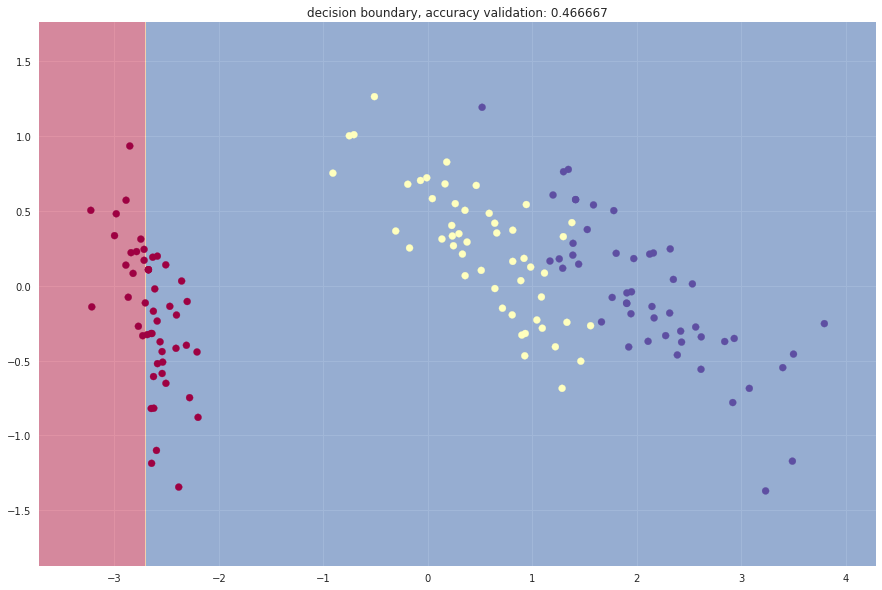

In [9]:
plt.figure(figsize=(15, 10))
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = 0.01
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = np.around(adaboost.predict(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha = 0.5)
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Spectral)
plt.title('decision boundary, accuracy validation: %f'%(acc))
plt.show()